In [1]:
import platform
import matplotlib.pyplot as plt
import pandas as pd

tt_df = pd.read_csv('trump_senti_point.csv')
ht_df = pd.read_csv('harris_senti_point.csv')

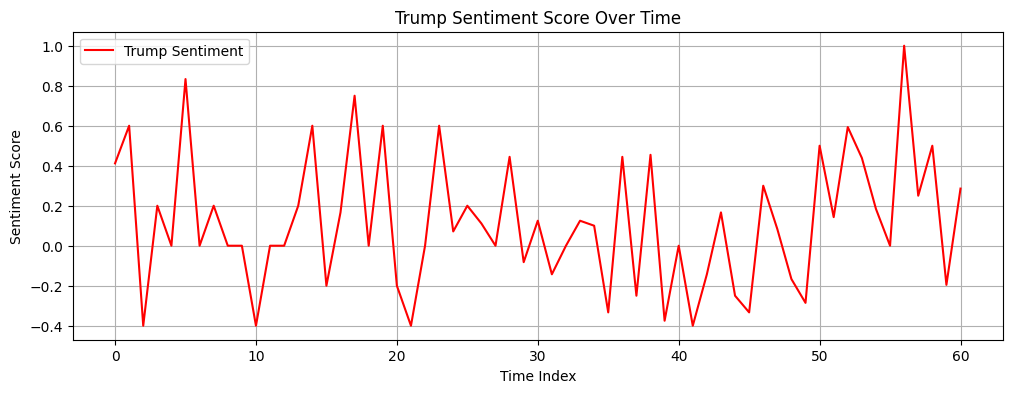

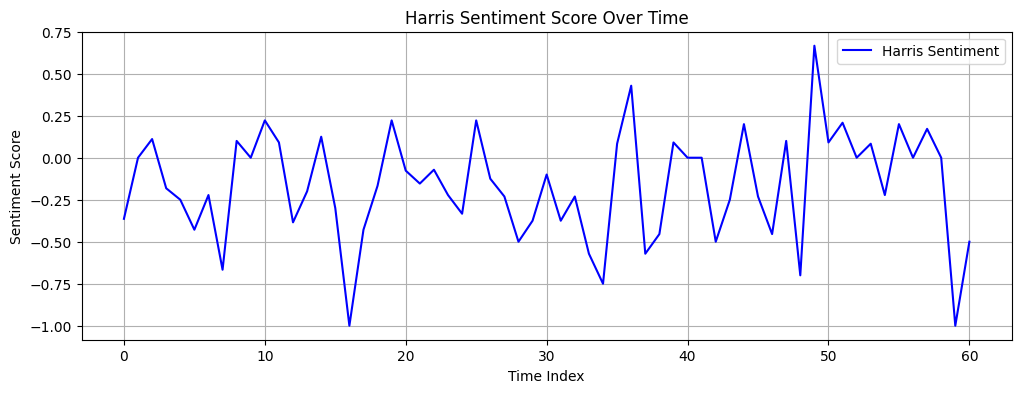

In [2]:
# Plot Trump sentiment score
plt.figure(figsize=(12, 4))
plt.plot(tt_df['sentiment'], label='Trump Sentiment', color='red')
plt.title('Trump Sentiment Score Over Time')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Harris sentiment score
plt.figure(figsize=(12, 4))
plt.plot(ht_df['sentiment'], label='Harris Sentiment', color='blue')
plt.title('Harris Sentiment Score Over Time')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# 트럼프의 감성점수
전체적으로 변동성이 크고, 불규칙한 파형을 보임.

특정 구간에서 급락/급등이 나타나며, 전반적인 방향성은 뚜렷하지 않음.

감성 점수의 범위는 비교적 넓은 편으로, 노이즈가 강한 시계열로 판단됨.

# 해리스의 감성점수
트럼프에 비해 다소 부드럽고 안정적인 흐름을 보임.

그러나 중간중간 급격한 변화가 있어 부분적으로 이벤트성 변동이 존재할 수 있음.

트렌드(상승/하락)보다는 단기 등락의 반복이 주요 특성.

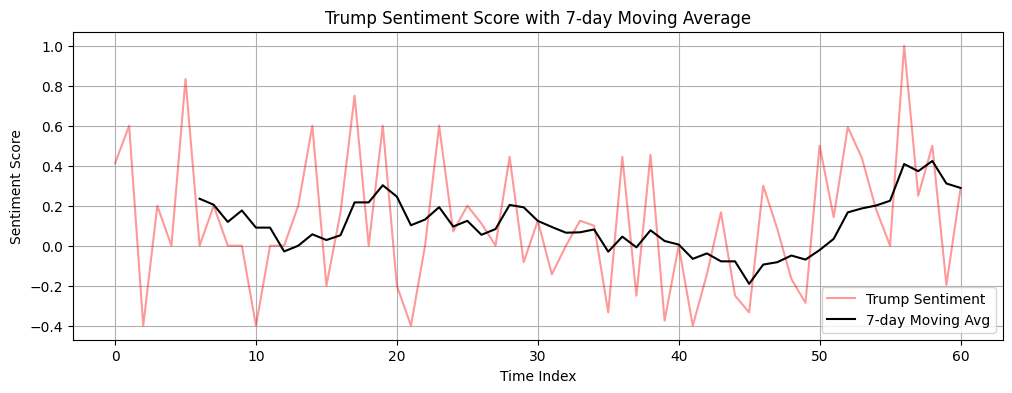

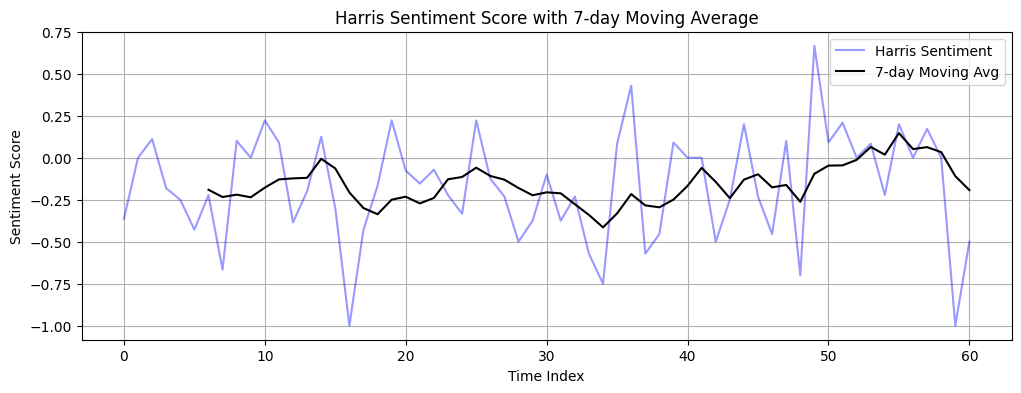

In [3]:
# 기초 통계량 확인
tt_stats = tt_df['sentiment'].describe()
ht_stats = ht_df['sentiment'].describe()

# 이동 평균 계산 (7일 기준)
tt_df['rolling_mean'] = tt_df['sentiment'].rolling(window=7).mean()
ht_df['rolling_mean'] = ht_df['sentiment'].rolling(window=7).mean()

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 트럼프 감성 점수 + 이동평균 시각화
plt.figure(figsize=(12, 4))
plt.plot(tt_df['sentiment'], label='Trump Sentiment', alpha=0.4, color='red')
plt.plot(tt_df['rolling_mean'], label='7-day Moving Avg', color='black')
plt.title('Trump Sentiment Score with 7-day Moving Average')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# 해리스 감성 점수 + 이동평균 시각화
plt.figure(figsize=(12, 4))
plt.plot(ht_df['sentiment'], label='Harris Sentiment', alpha=0.4, color='blue')
plt.plot(ht_df['rolling_mean'], label='7-day Moving Avg', color='black')
plt.title('Harris Sentiment Score with 7-day Moving Average')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 준비
tt_lstm_list = tt_df['sentiment'].values.tolist()
ht_lstm_list = ht_df['sentiment'].values.tolist()

window_size = 7
X_tt, Y_tt = [], []
X_th, Y_th = [], []

for i in range(len(ht_lstm_list) - window_size):
    X_tt.append([tt_lstm_list[i + j] for j in range(window_size)])
    X_th.append([ht_lstm_list[i + j] for j in range(window_size)])
    Y_tt.append(tt_lstm_list[window_size + i])
    Y_th.append(ht_lstm_list[window_size + i])

X_tt = np.array(X_tt).reshape(-1, window_size, 1)
X_th = np.array(X_th).reshape(-1, window_size, 1)
Y_tt = np.array(Y_tt)
Y_th = np.array(Y_th)

# 학습/테스트 분할
split_idx = 46
X_tt_train, X_tt_test = X_tt[:split_idx], X_tt[split_idx:]
Y_tt_train, Y_tt_test = Y_tt[:split_idx], Y_tt[split_idx:]

X_th_train, X_th_test = X_th[:split_idx], X_th[split_idx:]
Y_th_train, Y_th_test = Y_th[:split_idx], Y_th[split_idx:]

# 트럼프 모델
tt_model = Sequential()
tt_model.add(LSTM(128, input_shape=(7, 1)))
tt_model.add(Dropout(0.2))
tt_model.add(Dense(1, activation='linear'))
tt_model.compile(loss='mse', optimizer='adam')
tt_model.fit(X_tt_train, Y_tt_train, epochs=50, batch_size=1, verbose=0)

# 해리스 모델
th_model = Sequential()
th_model.add(LSTM(128, input_shape=(7, 1)))
th_model.add(Dropout(0.2))
th_model.add(Dense(1, activation='linear'))
th_model.compile(loss='mse', optimizer='adam')
th_model.fit(X_th_train, Y_th_train, epochs=50, batch_size=1, verbose=0)

# 예측
tt_pred = tt_model.predict(X_tt_test)
th_pred = th_model.predict(X_th_test)

# 평가 지표 계산
tt_mae = mean_absolute_error(Y_tt_test, tt_pred)
tt_rmse = mean_squared_error(Y_tt_test, tt_pred)**0.5
th_mae = mean_absolute_error(Y_th_test, th_pred)
th_rmse = mean_squared_error(Y_th_test, th_pred)**0.5

# 결과 정리
import pandas as pd
result_df = pd.DataFrame({
    'Candidate': ['Trump', 'Harris'],
    'MAE': [tt_mae, th_mae],
    'RMSE': [tt_rmse, th_rmse]
})

result_df

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


,Candidate,MAE,RMSE
0,Trump,0.391000,0.492717
1,Harris,0.441949,0.503013


절대 오차가 RMSE와 비슷하므로 극단적인 이상 예측(outlier error)은 적은 편

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 준비
tt_lstm_list = tt_df['sentiment'].values.tolist()
window_size = 7
X_tt, Y_tt = [], []

for i in range(len(tt_lstm_list) - window_size):
    X_tt.append([tt_lstm_list[i + j] for j in range(window_size)])
    Y_tt.append(tt_lstm_list[window_size + i])

X_tt = np.array(X_tt).reshape(-1, window_size, 1)
Y_tt = np.array(Y_tt)

# 훈련/테스트 분리
split_idx = 46
X_tt_train, X_tt_test = X_tt[:split_idx], X_tt[split_idx:]
Y_tt_train, Y_tt_test = Y_tt[:split_idx], Y_tt[split_idx:]

# 모델 구성
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

# 콜백 정의
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_tt_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
model.fit(X_tt_train, Y_tt_train,
          validation_split=0.2,
          epochs=100,
          batch_size=4,
          callbacks=[early_stop, checkpoint],
          verbose=1)

# 예측 및 평가
tt_pred = model.predict(X_tt_test)
mae = mean_absolute_error(Y_tt_test, tt_pred)
rmse = mean_squared_error(Y_tt_test, tt_pred)**0.5

print(f"Trump - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/9 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0934

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0837 - val_loss: 0.0981
Epoch 2/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - loss: 0.1358

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1272 - val_loss: 0.0968
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0680 - val_loss: 0.0982
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0705 - val_loss: 0.0985
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1074 - val_loss: 0.0989
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1094 - val_loss: 0.0992
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0861 - val_loss: 0.1011
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0971 - val_loss: 0.1011
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1000 - val_loss: 0.1032
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1014 - val_loss: 0.1036
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1093 - val_loss: 0.1068
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0747 - val_loss: 0.1049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Trump - MAE: 0.3160, RMSE: 0.4040


In [6]:
# Harris 감성 점수 준비
ht_lstm_list = ht_df['sentiment'].values.tolist()
window_size = 7
X_ht, Y_ht = [], []

for i in range(len(ht_lstm_list) - window_size):
    X_ht.append([ht_lstm_list[i + j] for j in range(window_size)])
    Y_ht.append(ht_lstm_list[window_size + i])

X_ht = np.array(X_ht).reshape(-1, window_size, 1)
Y_ht = np.array(Y_ht)

# 훈련/테스트 분할
split_idx = 46
X_ht_train, X_ht_test = X_ht[:split_idx], X_ht[split_idx:]
Y_ht_train, Y_ht_test = Y_ht[:split_idx], Y_ht[split_idx:]

# 모델 구성
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

# 콜백 정의
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_ht_model.h5', monitor='val_loss', save_best_only=True)

# 학습
model.fit(X_ht_train, Y_ht_train,
          validation_split=0.2,
          epochs=100,
          batch_size=4,
          callbacks=[early_stop, checkpoint],
          verbose=1)

# 예측 및 평가
ht_pred = model.predict(X_ht_test)
mae = mean_absolute_error(Y_ht_test, ht_pred)
rmse = mean_squared_error(Y_ht_test, ht_pred)**0.5

print(f"Harris - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/9 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1355

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1277 - val_loss: 0.1449
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1520 - val_loss: 0.1598
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1112 - val_loss: 0.1553
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0792 - val_loss: 0.1563
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0923 - val_loss: 0.1515
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0775 - val_loss: 0.1746
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0920 - val_loss: 0.1625
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0676 - val_loss: 0.1517
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0866 - val_loss: 0.1749
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0766 - val_loss: 0.1617
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1221 - val_loss: 0.1618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Harris - MAE: 0.2879, RMSE: 0.3904


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 트럼프 감성 점수 시계열
tt_series = tt_df['sentiment']

# 훈련/테스트 분할
window_size = 7
train_size = 46
train_data = tt_series[:train_size + window_size]
test_data = tt_series[train_size + window_size:]

# ARIMA 모델 학습 (기본적으로 p=7, d=1, q=0 설정)
arima_model = ARIMA(train_data, order=(7, 1, 0))
arima_result = arima_model.fit()

# 예측 (동일 길이 예측)
forecast_steps = len(test_data)
arima_pred = arima_result.forecast(steps=forecast_steps)

# 성능 평가
mae_arima = mean_absolute_error(test_data, arima_pred)
rmse_arima = mean_squared_error(test_data, arima_pred)**0.5

# 결과 출력
arima_eval = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [mae_arima],
    'RMSE': [rmse_arima]
})

arima_eval

,Model,MAE,RMSE
0,ARIMA,0.244881,0.331909


In [8]:
# Harris 감성 점수 시계열
ht_series = ht_df['sentiment']

# 훈련/테스트 분할
train_data_ht = ht_series[:train_size + window_size]
test_data_ht = ht_series[train_size + window_size:]

# ARIMA 모델 학습 (p=7, d=1, q=0 동일 설정)
arima_model_ht = ARIMA(train_data_ht, order=(7, 1, 0))
arima_result_ht = arima_model_ht.fit()

# 예측
forecast_steps_ht = len(test_data_ht)
arima_pred_ht = arima_result_ht.forecast(steps=forecast_steps_ht)

# 성능 평가
mae_arima_ht = mean_absolute_error(test_data_ht, arima_pred_ht)
rmse_arima_ht = mean_squared_error(test_data_ht, arima_pred_ht)**0.5

# 결과 정리
arima_eval_ht = pd.DataFrame({
    'Candidate': ['Harris'],
    'Model': ['ARIMA'],
    'MAE': [mae_arima_ht],
    'RMSE': [rmse_arima_ht]
})

arima_eval_ht

,Candidate,Model,MAE,RMSE
0,Harris,ARIMA,0.260116,0.435647


In [9]:
def recursive_lstm_forecast(model, seed_sequence, days=5):
    """
    model: 학습된 LSTM 모델
    seed_sequence: 마지막 7일 감성 점수 (numpy array of shape (7,))
    days: 몇일 뒤까지 예측할지
    """
    input_seq = seed_sequence.reshape(1, 7, 1)
    predictions = []

    for _ in range(days):
        pred = model.predict(input_seq)[0][0]
        predictions.append(pred)

        # 새로운 예측값을 시퀀스에 추가하고 가장 오래된 값을 제거
        new_seq = np.append(input_seq[0, 1:, 0], pred)
        input_seq = new_seq.reshape(1, 7, 1)

    return predictions

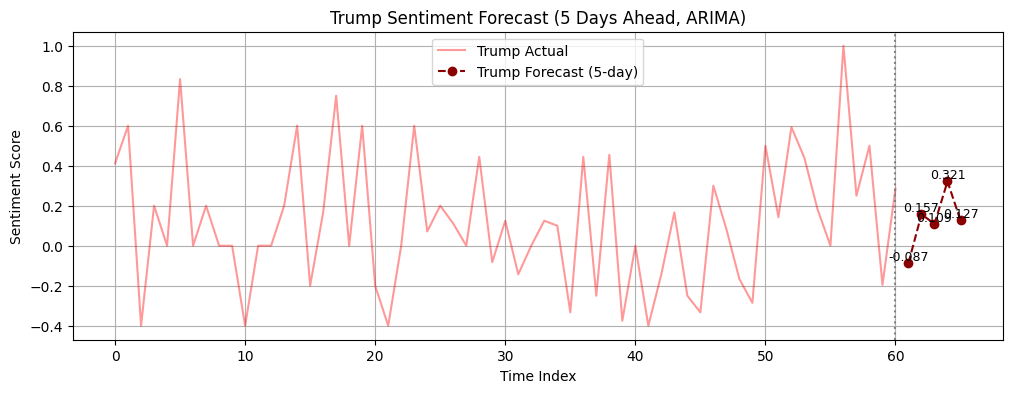

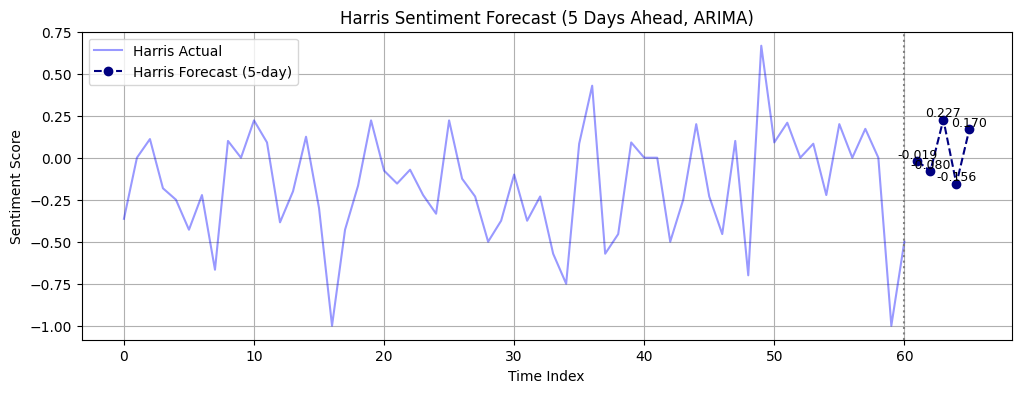

In [10]:
# 다시 준비: 훈련 구간 재정의
last_train_tt = tt_series[:train_size + window_size]
last_train_ht = ht_series[:train_size + window_size]

# 트럼프용 ARIMA 재귀 예측 (5일)
seed_tt = last_train_tt.copy()
preds_tt = []

for _ in range(5):
    model_tt = ARIMA(seed_tt, order=(7, 1, 0)).fit()
    next_pred = model_tt.forecast(steps=1).values[0]
    preds_tt.append(next_pred)
    seed_tt = pd.concat([seed_tt, pd.Series([next_pred])], ignore_index=True)

# 해리스용 ARIMA 재귀 예측 (5일)
seed_ht = last_train_ht.copy()
preds_ht = []

for _ in range(5):
    model_ht = ARIMA(seed_ht, order=(7, 1, 0)).fit()
    next_pred = model_ht.forecast(steps=1).values[0]
    preds_ht.append(next_pred)
    seed_ht = pd.concat([seed_ht, pd.Series([next_pred])], ignore_index=True)

# 트럼프 5일 예측값 및 날짜 인덱스
tt_forecast_index = range(len(tt_series), len(tt_series) + 5)
tt_forecast_values = preds_tt

# 해리스 5일 예측값 및 날짜 인덱스
ht_forecast_index = range(len(ht_series), len(ht_series) + 5)
ht_forecast_values = preds_ht

# 시각화: Trump + 예측값 텍스트 추가
plt.figure(figsize=(12, 4))
plt.plot(tt_series, label='Trump Actual', color='red', alpha=0.4)
plt.plot(tt_forecast_index, tt_forecast_values, marker='o', linestyle='--', color='darkred', label='Trump Forecast (5-day)')
for x, y in zip(tt_forecast_index, tt_forecast_values):
    plt.text(x, y, f'{y:.3f}', fontsize=9, ha='center', va='bottom')
plt.axvline(len(tt_series) - 1, color='gray', linestyle=':')
plt.title('Trump Sentiment Forecast (5 Days Ahead, ARIMA)')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# 시각화: Harris + 예측값 텍스트 추가
plt.figure(figsize=(12, 4))
plt.plot(ht_series, label='Harris Actual', color='blue', alpha=0.4)
plt.plot(ht_forecast_index, ht_forecast_values, marker='o', linestyle='--', color='navy', label='Harris Forecast (5-day)')
for x, y in zip(ht_forecast_index, ht_forecast_values):
    plt.text(x, y, f'{y:.3f}', fontsize=9, ha='center', va='bottom')
plt.axvline(len(ht_series) - 1, color='gray', linestyle=':')
plt.title('Harris Sentiment Forecast (5 Days Ahead, ARIMA)')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# 데이터 준비
series = tt_df['sentiment']
results = []

# 범위 설정 (필요시 조절)
p_values = range(7, 14)
d_values = range(0, 2)
q_values = range(0, 4)

# 반복 탐색
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(series, order=(p,d,q))
                fitted = model.fit()
                aic = fitted.aic
                results.append(((p,d,q), aic))
            except:
                continue

# AIC 기준 가장 좋은 모델 찾기
results.sort(key=lambda x: x[1])
best_order, best_aic = results[0]
print(f'Best ARIMA(p,d,q): {best_order}, AIC: {best_aic:.2f}')

Best ARIMA(p,d,q): (7, 0, 2), AIC: 47.47


In [26]:
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# 데이터 준비
series = ht_df['sentiment']
results = []

# 범위 설정 (필요시 조절)
p_values = range(7, 14)
d_values = range(0, 2)
q_values = range(0, 4)

# 반복 탐색
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(series, order=(p,d,q))
                fitted = model.fit()
                aic = fitted.aic
                results.append(((p,d,q), aic))
            except:
                continue

# AIC 기준 가장 좋은 모델 찾기
results.sort(key=lambda x: x[1])
best_order, best_aic = results[0]
print(f'Best ARIMA(p,d,q): {best_order}, AIC: {best_aic:.2f}')

Best ARIMA(p,d,q): (7, 0, 3), AIC: 43.61


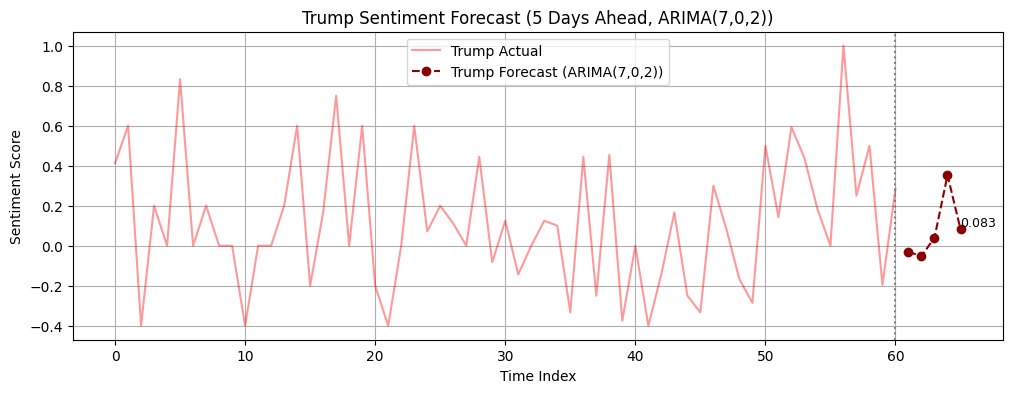

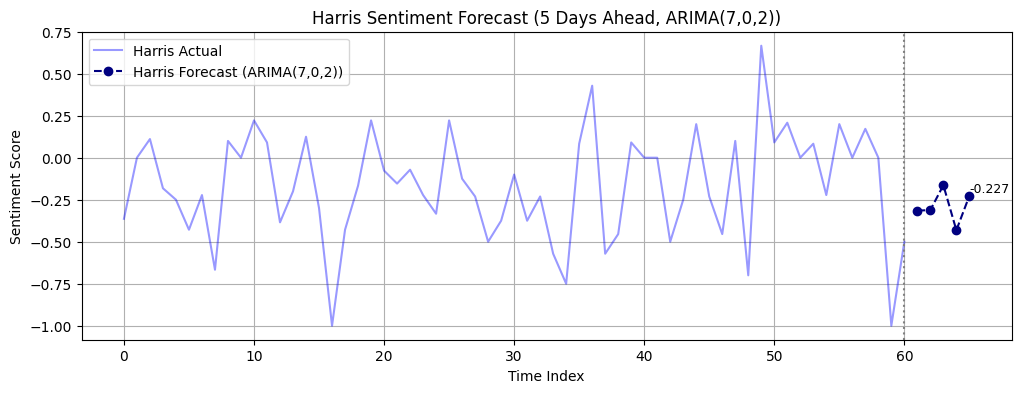

In [29]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# 훈련 구간 재정의 (기존 시계열 앞부분 사용)
last_train_tt = tt_series[:train_size + window_size]
last_train_ht = ht_series[:train_size + window_size]

# 트럼프용 ARIMA(7,0,2) 재귀 예측 (5일)
seed_tt = last_train_tt.copy()
preds_tt = []

for _ in range(5):
    model_tt = ARIMA(seed_tt, order=(7, 0, 2)).fit()
    next_pred = model_tt.forecast(steps=1).values[0]
    preds_tt.append(next_pred)
    seed_tt = pd.concat([seed_tt, pd.Series([next_pred])], ignore_index=True)

# 해리스용 ARIMA(7,0,2) 재귀 예측 (5일)
seed_ht = last_train_ht.copy()
preds_ht = []

for _ in range(5):
    model_ht = ARIMA(seed_ht, order=(7, 0, 2)).fit()
    next_pred = model_ht.forecast(steps=1).values[0]
    preds_ht.append(next_pred)
    seed_ht = pd.concat([seed_ht, pd.Series([next_pred])], ignore_index=True)

# 인덱스 설정
tt_forecast_index = range(len(tt_series), len(tt_series) + 5)
ht_forecast_index = range(len(ht_series), len(ht_series) + 5)

# 시각화: Trump
plt.figure(figsize=(12, 4))
plt.plot(tt_series, label='Trump Actual', color='red', alpha=0.4)
plt.plot(tt_forecast_index, preds_tt, marker='o', linestyle='--', color='darkred', label='Trump Forecast (ARIMA(7,0,2))')
for i, (x, y) in enumerate(zip(tt_forecast_index, preds_tt)):
    if i == 4:  # 마지막 값만 텍스트로 표시
        plt.text(x, y, f'{y:.3f}', fontsize=9, ha='left', va='bottom')
plt.axvline(len(tt_series) - 1, color='gray', linestyle=':')
plt.title('Trump Sentiment Forecast (5 Days Ahead, ARIMA(7,0,2))')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()


# 시각화: Harris
plt.figure(figsize=(12, 4))
plt.plot(ht_series, label='Harris Actual', color='blue', alpha=0.4)
plt.plot(ht_forecast_index, preds_ht, marker='o', linestyle='--', color='navy', label='Harris Forecast (ARIMA(7,0,2))')
for i, (x, y) in enumerate(zip(ht_forecast_index, preds_ht)):
    if i == 4:  # 마지막 값만 텍스트로 표시
        plt.text(x, y, f'{y:.3f}', fontsize=9, ha='left', va='bottom')
plt.axvline(len(ht_series) - 1, color='gray', linestyle=':')
plt.title('Harris Sentiment Forecast (5 Days Ahead, ARIMA(7,0,2))')
plt.xlabel('Time Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()